In [1]:
# Import libraries and dependencies
import numpy as np
import pandas as pd
import os
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import alpaca_trade_api as tradeapi
%matplotlib inline

In [2]:
np.random.seed(42)

# Portfolio Planner

In this activity, you will use the Alpaca api to grab historical data for a 60/40 portfolio using `SPY` to represent the stock portion and `AGG` to represent the bonds.

In [3]:
# Load .env enviroment variables
from dotenv import load_dotenv
load_dotenv()

# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

# api = tradeapi.REST()
api = tradeapi.REST(alpaca_api_key, alpaca_secret_key, api_version='v2')

# Data Collection

In this step, you will need to use the Alpaca api to fetch closing prices for the `SPY` and `AGG` tickers. Save the results as a pandas DataFrame

In [4]:
list_of_tickers = ["SPY", "AGG"]
# YOUR CODE HERE

# Set timeframe to '1D'
timeframe = '1D'

# Set start and end datetimes of 1 year, between now and 365 days ago.
end_date = datetime.now()
start_date = end_date + timedelta(-365)

# Get 1 year's worth of historical data for AAPL
df = api.get_barset(
    list_of_tickers,
    timeframe,
    limit=None,
    start=start_date,
    end=end_date,
    after=None,
    until=None,
).df

df.head()

AGG                                         SPY  \
                             open      high     low   close   volume     open   
2019-12-02 00:00:00-05:00  112.31  112.5100  112.29  112.48  5720136  314.327   
2019-12-03 00:00:00-05:00  112.80  113.1277  112.76  113.02  3547417  308.650   
2019-12-04 00:00:00-05:00  112.87  112.9500  112.68  112.80  3547118  310.700   
2019-12-05 00:00:00-05:00  112.58  112.7400  112.53  112.69  3052489  312.230   
2019-12-06 00:00:00-05:00  112.47  112.6800  112.41  112.54  4065089  314.120   

                                                             
                             high     low   close    volume  
2019-12-02 00:00:00-05:00  314.37  311.17  311.60  61594879  
2019-12-03 00:00:00-05:00  309.64  307.13  309.47  62363983  
2019-12-04 00:00:00-05:00  312.12  310.32  311.47  37810887  
2019-12-05 00:00:00-05:00  312.25  310.58  312.05  34436972  
2019-12-06 00:00:00-05:00  315.31  314.11  314.84  37930796

In [5]:
df.drop(columns=['open', 'high', 'low', 'volume'], level=1, inplace=True)
df.tail()

,AGG,SPY
,close,close
2020-04-20 00:00:00-04:00,117.10,281.61
2020-04-21 00:00:00-04:00,117.17,273.02
2020-04-22 00:00:00-04:00,117.09,279.91
2020-04-23 00:00:00-04:00,117.39,279.06
2020-04-24 00:00:00-04:00,117.35,283.04


# Monte Carlo Simulation

In this step, you will run Monte Carlo Simulations for your portfolio to model portfolio performance at different retirement ages. 

Complete the following steps:
1. Calculate the daily returns for the SPY and AGG closing prices.
2. Calculate volatility for both the SPY and AGG closing prices.
3. Find the last day's closing price for both stocks and save those as variables.
4. Run a Monte Carlo Simulation of at least 500 iterations and generate at least 30 years of closing prices

### HINTS:
There are 252 trading days per year, so the number of records to generate for each Monte Carlo run will be 252 days * 30 years

In [6]:
# Calculate the daily roi for the stocks
# YOUR CODE HERE

daily_returns = df.pct_change()
daily_returns.head()

,AGG,SPY
,close,close
2019-12-02 00:00:00-05:00,NaN,NaN
2019-12-03 00:00:00-05:00,0.004801,-0.006836
2019-12-04 00:00:00-05:00,-0.001947,0.006463
2019-12-05 00:00:00-05:00,-0.000975,0.001862
2019-12-06 00:00:00-05:00,-0.001331,0.008941


In [7]:
avg_daily_return_agg = daily_returns.mean()['AGG']['close']
avg_daily_return_spy = daily_returns.mean()['SPY']['close']

In [8]:
# Calculate volatility
# YOUR CODE HERE

std_dev_daily_return_agg = daily_returns.std()['AGG']['close']
std_dev_daily_return_spy = daily_returns.std()['SPY']['close']

In [9]:
# Save the last day's closing price
# YOUR CODE HERE

agg_last_price = df['AGG']['close'][-1]
spy_last_price = df['SPY']['close'][-1]

In [10]:
# Setup the Monte Carlo Parameters
number_simulations = 500
number_records = 252 * 30
monte_carlo = pd.DataFrame()

simulated_price_df = pd.DataFrame()
portfolio_cumulative_returns = pd.DataFrame()

In [11]:
# Run the Monte Carlo Simulation
for x in range(number_simulations):
    # Initialize the simulated prices list with the last closing price of `AGG` and `SPY`
    simulated_agg_prices = [agg_last_price]
    simulated_spy_prices = [spy_last_price]
    # Simulate the returns for 252 * 30
    for i in range(number_records):
        # Calculate the simulated price using the last price within the list
        #ASSUMPTION: .normal distribution
        simulated_agg_price = simulated_agg_prices[-1] * (1 + np.random.normal(avg_daily_return_agg, std_dev_daily_return_agg))
        simulated_spy_price = simulated_spy_prices[-1] * (1 + np.random.normal(avg_daily_return_spy, std_dev_daily_return_spy))
        # Append the simulated price to the list
        simulated_agg_prices.append(simulated_agg_price)
        simulated_spy_prices.append(simulated_spy_price)
    # Append a simulated prices of each simulation to DataFrame
    simulated_price_df["AGG prices"] = pd.Series(simulated_agg_prices)
    simulated_price_df["SPY prices"] = pd.Series(simulated_spy_prices)
    # Calculate the daily returns of simulated prices
    simulated_daily_returns = simulated_price_df.pct_change()
    # Set the portfolio weights (60% Stocks:SPY; 40% Bonds:AGG)
    weights = [0.40, 0.60]
    # Use the `dot` function with the weights to multiply weights with each column's simulated daily returns
    portfolio_daily_returns = simulated_daily_returns.dot(weights)
    # Calculate the normalized, cumulative return series
    portfolio_cumulative_returns[x] = (1 + portfolio_daily_returns.fillna(0)).cumprod()
    
# Print records from the DataFrame
portfolio_cumulative_returns.head()

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.999029,0.999083,0.992256,1.018195,1.043403,0.975565,0.986581,1.048953,1.000541,0.978979,...,1.005236,0.968455,1.004330,1.007545,0.983231,1.009540,1.003406,1.023544,0.990025,0.976543
2,1.029079,1.012550,1.007948,0.980798,1.031475,0.971714,0.971817,1.020999,0.995098,0.967343,...,1.016865,0.972729,1.007442,1.018465,0.984271,0.961687,1.004893,1.015049,0.979248,0.989573
3,1.023714,1.007751,1.005820,0.983660,1.021188,0.943816,0.984449,0.994712,0.992220,0.996159,...,1.017918,0.946727,1.007785,1.032911,0.965110,0.969032,1.023672,0.987500,0.986176,1.003950
4,1.043525,1.014117,1.021323,0.997934,1.041707,0.953303,1.000903,0.968934,0.996600,1.011527,...,1.004825,0.957724,1.007200,1.005483,0.968357,0.963580,1.010419,0.996656,0.976892,1.004128


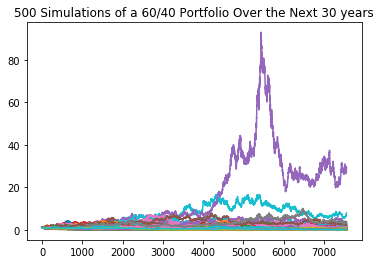

In [12]:
# Visualize the Simulation
# YOUR CODE HERE

plot_title = f"{x+1} Simulations of a 60/40 Portfolio Over the Next 30 years"
portfolio_cumulative_returns.plot(legend=None, title=plot_title)

In [13]:
# Select the last row for the cumulative returns (cumulative returns at 30 years)
# YOUR CODE HERE

ending_cumulative_returns = portfolio_cumulative_returns.iloc[-1, :]
ending_cumulative_returns.head()

0    0.107586
1    0.069887
2    0.078095
3    0.028584
4    0.076340
Name: 7560, dtype: float64

In [14]:
# Select the last row for the cumulative returns (cumulative returns at 20 years)
# YOUR CODE HERE

ending_cumulative_returns = portfolio_cumulative_returns.iloc[-2520]
ending_cumulative_returns.head()

0    0.224574
1    0.170490
2    0.108960
3    0.070821
4    0.876912
Name: 5041, dtype: float64

In [15]:
# Display the 90% confidence interval for the ending returns
# YOUR CODE HERE

confidence_interval = ending_cumulative_returns.quantile(q=[0.05, 0.95])
confidence_interval

0.05    0.027781
0.95    1.821582
Name: 5041, dtype: float64

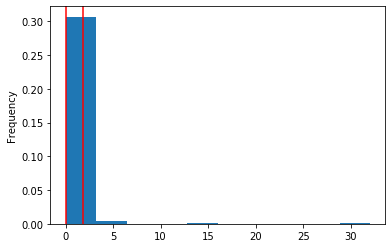

In [16]:
# Visualize the distribution of the ending returns
# YOUR CODE HERE

plt.figure();
ending_cumulative_returns.plot(kind='hist', density=True, bins=10)
plt.axvline(confidence_interval.iloc[0], color='r')
plt.axvline(confidence_interval.iloc[1], color='r')

---

# Retirement Analysis

In this section, you will use the monte carlo model to answer the following retirement planning questions:

1. What are the expected cumulative returns at 30 years for the 10th, 50th, and 90th percentiles?
2. Given an initial investment of `$20,000`, what is the expected portfolio return in dollars at the 10th, 50th, and 90th percentiles?
3. Given the current projected annual income from the Plaid analysis, will a 4% withdraw rate from the retirement portfolio meet or exceed that value at the 10th percentile?
4. How would a 50% increase in the initial investment amount affect the 4% retirement withdrawal?

### What are the expected cumulative returns at 30 years for the 10th, 50th, and 90th percentiles?

In [20]:
#10th percentile expected cumulative returns
ending_cumulative_returns_10 = ending_cumulative_returns.quantile(q=[.1])
ending_cumulative_returns_10

0.1    0.046015
Name: 5041, dtype: float64

In [21]:
#50th percentile expected cumulative returns
ending_cumulative_returns_50 = ending_cumulative_returns.quantile(q=[.5])
ending_cumulative_returns_50

0.5    0.236957
Name: 5041, dtype: float64

In [22]:
#90th percentile expected cumulative returns
ending_cumulative_returns_90 = ending_cumulative_returns.quantile(q=[.9])
ending_cumulative_returns_90

0.9    1.165022
Name: 5041, dtype: float64

### Given an initial investment of `$20,000`, what is the expected portfolio return in dollars at the 10th, 50th, and 90th percentiles?

In [23]:
# YOUR CODE HERE

# Set initial investment
initial_investment = 20000
# Calculate investment profit/loss of lower and upper bound cumulative portfolio returns
investment_pnl_10 = initial_investment * ending_cumulative_returns_10.iloc[0]
investment_pnl_50 = initial_investment * ending_cumulative_returns_50.iloc[0]
investment_pnl_90 = initial_investment * ending_cumulative_returns_90.iloc[0]

investment_pnl_10_rounded = np.round(investment_pnl_10, 2)
investment_pnl_50_rounded = np.round(investment_pnl_50, 2)
investment_pnl_90_rounded = np.round(investment_pnl_90, 2)

# Print the results
print(f"At the 10th percentile, an initial investment of $20,000 in the portfolio "
      f"over the next 30 years will be" 
      f" ${investment_pnl_10_rounded}."
      f" At the 50th percentile, an initial investment of $20,000 in the portfolio "
      f"over the next 30 years will be"
      f" ${investment_pnl_50_rounded}."
      f" At the 90th percentile, an initial investment of $20,000 in the portfolio "
      f"over the next 30 years will be"
      f" ${investment_pnl_90_rounded}")

At the 10th percentile, an initial investment of $20,000 in the portfolio over the next 30 years will be $920.29. At the 50th percentile, an initial investment of $20,000 in the portfolio over the next 30 years will be $4739.13. At the 90th percentile, an initial investment of $20,000 in the portfolio over the next 30 years will be $23300.44


### Given the current projected annual income from the Plaid analysis, will a 4% withdraw rate from the retirement portfolio meet or exceed that value at the 10th percentile?

Note: This is effectively saying that 90% of the expected returns will be greater than the return at the 10th percentile, so this can help measure the uncertainty about having enough funds at retirement

# YOUR CODE HERE 

**Withdrawal Analysis if Initial Investment is $20,000**

At the 10th percentile your portfolio will only be worth ~920. The projected yearly income is $6,085. If the goal is to withdraw 4% of your portfolio such that it equals your currently projected yearly income, you will not have not nearly enough money to retire. 

### How would a 50% increase in the initial investment amount affect the 4% retirement withdrawal?

In [24]:
# YOUR CODE HERE

# Set initial investment
initial_investment_2 = 30000
# Calculate investment profit/loss of lower and upper bound cumulative portfolio returns
investment_pnl_10_2 = initial_investment_2 * ending_cumulative_returns_10.iloc[0]

investment_pnl_10_2_rounded = np.round(investment_pnl_10_2, 2)

# Print the results
print(f"At the 10th percentile, an initial investment of $30,000 in the portfolio "
      f"over the next 30 years will be"
      f" ${investment_pnl_10_2_rounded}")

At the 10th percentile, an initial investment of $30,000 in the portfolio over the next 30 years will be $1380.44


**Withdrawal Analysis if initial investment is increased 50% to $30,000**

At the 10th percentile, the value of portfolio will only increase to ~$1380. This is still not nearly sufficient to retire. 

### Optional Challenge

In this section, you will calculate and plot the cumulative returns for the median and 90% confidence intervals. This plot shows the expected cumulative returns for any given day between the first day and the last day of investment. 

In [ ]:
# YOUR CODE HERE